# Create flying node graph
This Notebook will create the graph we will use for flying our drone. We do it once so we don't have to do it everytime we load the simulator.

## Imports

In [2]:
import networkx as nx
nx.__version__

import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from bresenham import bresenham
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
from planning_utils import heuristic, create_grid
import time

%matplotlib inline

## Load Data

In [3]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


# Voronoi graph method

In [4]:
print('start')
# Define a flying altitude (feel free to change this)
drone_altitude = 5
safety_distance = 3
grid, points, north_offset, east_offset = create_grid(data, drone_altitude, safety_distance)
print('done')

start
done


In [5]:
print('start')
# Create a voronoi graph based on
# location of obstacle centres
voronoi_graph = Voronoi(points)

# Check each edge from graph.ridge_vertices for collision
edges = []
vertices = set()
g = nx.Graph()
for v in voronoi_graph.ridge_vertices:
    p1 = voronoi_graph.vertices[v[0]]
    p2 = voronoi_graph.vertices[v[1]]
    cells = list(bresenham(int(p1[0]), int(p1[1]), int(p2[0]), int(p2[1])))
    hit = False

    for c in cells:
        # First check if we're off the map
        if np.amin(c) < 0 or c[0] >= grid.shape[0] or c[1] >= grid.shape[1]:
            hit = True
            break
        # Next check if we're in collision
        if grid[c[0], c[1]] == 1:
            hit = True
            break

    # If the edge does not hit on obstacle
    # add it to the list
    if not hit:
        g.add_edge((p1[0], p1[1], drone_altitude),(p2[0], p2[1], drone_altitude), weight=1)

print('done')

start
done


In [7]:
print('Found %5d edges' % len(g.edges))
print('Found %5d nodes' % len(g.nodes))
print('Grid: ', grid.shape)

Found  1895 edges
Found  1965 nodes
Grid:  (921, 921)


## Save to pickle

In [8]:
import pickle

# Dump the graph with Pickle
pkl_filename = 'graph.voronoi.p'

try:
    with open(pkl_filename, 'wb+') as pfile:
        print('Saving to pickle file ', pkl_filename)
        pickle.dump(
        {
            'graph': g,
        },
        pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to ', pkl_filename, ':', e)

print('done')

Saving to pickle file  graph.voronoi.p
done


## Load from pickle

In [9]:
pkl_filename = 'graph.voronoi.p'
with open(pkl_filename, "rb") as pfile:
    print('Reading pickle')
    dist_pickle = pickle.load(pfile)

    g = dist_pickle["graph"]

print('done')

Reading pickle
done


## Visualize graph

start


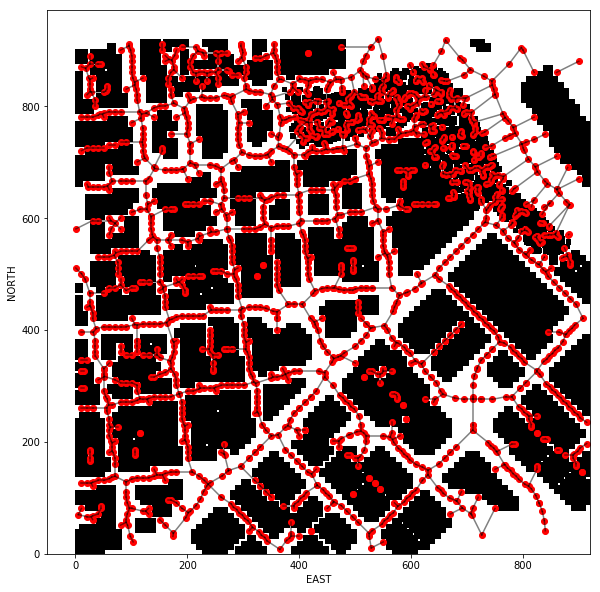

done


In [20]:
import matplotlib.pyplot as plt
print('start')
# Plot it up!
fig = plt.figure(figsize=(10,10))
plt.imshow(grid, origin='lower', cmap='Greys') 

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1], n2[1]], [n1[0], n2[0]], 'black', alpha=0.5)
    
# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1], n1[0], c='red')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()
print('done')

## A*

In [44]:
from planning_utils import a_star_graph

rnd = np.random.randint(len(g.nodes))
start = list(g.nodes)[rnd]
print('Start: ', rnd)
rnd = np.random.randint(len(g.nodes))
print('Goal: ', rnd)
goal = list(g.nodes)[rnd]

path, cost = a_star_graph(g, heuristic, start, goal)
print(len(path), path)

path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    print(n1, n2)

Start:  831
Goal:  8
Found a path.
57 [(290.7611361562489, 430.7684576937493, 5), (315.76114, 445.76846, 5), (323.76114, 445.76846, 5), (342.42783202225417, 459.1018114444672, 5), (348.838057892751, 462.30692568579923, 5), (351.67021033141174, 469.85933372769733, 5), (352.1897110510204, 470.76846, 5), (353.8380622130178, 474.6146127662722, 5), (358.76114, 480.76846, 5), (370.76114, 500.76846, 5), (380.76114, 510.76846, 5), (390.7611974999563, 520.7685174999563, 5), (403.26110072914287, 528.2684559374982, 5), (404.0944374999812, 530.76846, 5), (407.79816473938746, 552.990723436202, 5), (400.76114, 558.2684937499987, 5), (385.761145000005, 565.768494999995, 5), (377.4278066666667, 574.1018333333334, 5), (376.76114, 576.7685, 5), (368.76114, 588.7685, 5), (362.76114, 592.7685, 5), (358.7611427999969, 598.7684958000046, 5), (344.5111366406253, 608.2684951562503, 5), (339.0944801555575, 619.1018056888905, 5), (339.09447292962886, 619.1018418185163, 5), (325.76110623339406, 625.7685204332885